# Data Exploration

The purpose of this notebook is to explore the **training dataset**.

In [ ]:
import os
import sys

import pandas as pd
import numpy as np

import spacy
nlp = spacy.load("en_core_web_md")
import nltk
from nltk import word_tokenize, sent_tokenize
import textstat

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from scipy import stats
import statsmodels.api as sm
from scipy.stats import f_oneway, bartlett, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sys.path.insert(0, '../src')
import config

In [ ]:
# global settings

plot_path = "../reports/figures/"
processed = "../data/processed/"
plt.style.use(['science', 'no-latex', 'high-vis'])
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
STOPWORDS = []

In [ ]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,attack,text
0,348598183,0,which may contain more details
1,61527923,1,"Regardless, the point is that I am willing to ..."
2,325989249,0,Lede \nI'm reverting (again) the additions to...
3,197250961,0,I just came to this page and was wondering why...
4,116195271,1,It's worth having an illustration. The Type 2...


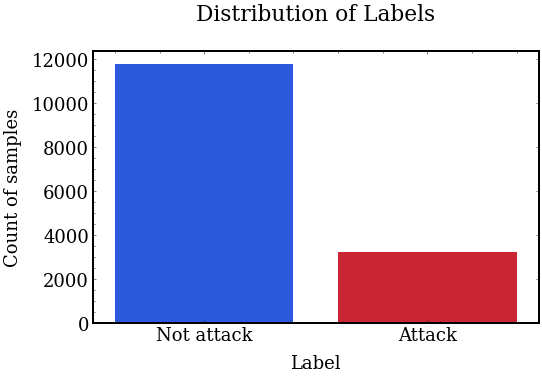

In [ ]:
# class imbalance plot
plt.figure(figsize=(8,5))
ax = sns.countplot(x='attack', data=df)
ax.set_title("Distribution of Labels\n")
ax.set_xlabel("Label", labelpad=10)
ax.set_xticklabels(['Not attack', 'Attack'])
ax.set_ylabel("Count of samples", labelpad=10)
plt.savefig(os.path.join(plot_path, "class_imbalance.png"), dpi=300)
plt.show()

In [ ]:
df.attack.value_counts()

0    11778
1     3222
Name: attack, dtype: int64

## Descriptive Text Features

In [ ]:
df.head()

,id,attack,text
0,348598183,0,which may contain more details
1,61527923,1,"Regardless, the point is that I am willing to ..."
2,325989249,0,Lede \nI'm reverting (again) the additions to...
3,197250961,0,I just came to this page and was wondering why...
4,116195271,1,It's worth having an illustration. The Type 2...


In [ ]:
def basic_descr_features(df):
    """
    Create new numeric features that describe the text
    """

    df['char_count'] = df.text.apply(textstat.char_count)
    df['word_count'] = df.text.apply(textstat.lexicon_count)
    df['syllable_count'] = df.text.apply(textstat.syllable_count)
    df['sentence_count'] = df.text.apply(textstat.sentence_count)
    df['avg_sentence_length'] = df.text.apply(textstat.avg_sentence_length)
    df['avg_char_word'] = df.text.apply(textstat.avg_character_per_word)
    df['avg_syll_word'] = df.text.apply(textstat.avg_syllables_per_word)
    df['flesch_reading_ease'] = df.text.apply(textstat.flesch_reading_ease)
    df['ari'] = df.text.apply(textstat.automated_readability_index)
    df['dale_chall'] = df.text.apply(textstat.dale_chall_readability_score)

    return df

def advanced_descr_features(df):
    """
    Create advanced numeric features that describe the text
    Uses spacy's default NLP pipeline
    """

    # filter
    df['nlp'] = df.text.apply(nlp)
    df['nouns'] = df.nlp.apply(lambda x: [tok.lower_ for tok in x if tok.pos_ == 'NOUN' or tok.pos_ == 'PROPN'])
    df['verbs'] = df.nlp.apply(lambda x: [tok.lower_ for tok in x if tok.pos_ == 'VERB'])
    df['pronouns'] = df.nlp.apply(lambda x: [tok.lower_ for tok in x if tok.pos_ == 'PRON'])
    df['puncts'] = df.nlp.apply(lambda x: [tok.lower_ for tok in x if tok.is_punct])
    df['digits'] = df.nlp.apply(lambda x: [tok.lower_ for tok in x if tok.is_digit])
    df['caps_word'] = df.text.apply(lambda x: [word for word in x.split() if word.isupper() and len(word) > 1])
    # caps_words should exclude ones like 'I' or 'A'
    
    # make counts
    df['nouns_count'] = df['nouns'].apply(len)
    df['verbs_count'] = df['verbs'].apply(len)
    df['pronouns_count'] = df['pronouns'].apply(len)
    df['puncts_count'] = df['puncts'].apply(len)
    df['digits_count'] = df['digits'].apply(len)
    df['caps_word_count'] = df['caps_word'].apply(len)

    return df

In [ ]:
new_df = basic_descr_features(df)
new_df.head()

,id,attack,text,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,flesch_reading_ease,ari,dale_chall
0,348598183,0,which may contain more details,26,5,7,1,5.0,5.20,1.4,83.32,5.6,10.20
1,61527923,1,"Regardless, the point is that I am willing to ...",264,55,87,1,55.0,4.80,1.6,15.65,28.7,9.81
2,325989249,0,Lede \nI'm reverting (again) the additions to...,308,63,90,3,21.0,4.89,1.4,67.08,12.1,7.69
3,197250961,0,I just came to this page and was wondering why...,159,41,51,1,41.0,3.88,1.2,63.70,17.3,6.83
4,116195271,1,It's worth having an illustration. The Type 2...,117,21,39,1,21.0,5.57,1.9,24.78,15.3,8.44


In [ ]:
new_df = advanced_descr_features(new_df)
new_df.head()

,id,attack,text,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,...,pronouns,puncts,digits,caps_word,nouns_count,verbs_count,pronouns_count,puncts_count,digits_count,caps_word_count
0,348598183,0,which may contain more details,26,5,7,1,5.0,5.20,1.4,...,[],[],[],[],1,1,0,0,0,0
1,61527923,1,"Regardless, the point is that I am willing to ...",264,55,87,1,55.0,4.80,1.6,...,"[i, what, you, i, my, you, me, you, your]","[,, ., ., ,, -, .]",[],[],10,9,9,6,0,0
2,325989249,0,Lede \nI'm reverting (again) the additions to...,308,63,90,3,21.0,4.89,1.4,...,"[i, it, they]","[(, ), ., (, ), (, ), -, ., ,, ,, .]",[],[],16,8,3,12,0,0
3,197250961,0,I just came to this page and was wondering why...,159,41,51,1,41.0,3.88,1.2,...,"[i, there, me, i, her, i, it]","[,]",[],[],7,5,7,1,0,0
4,116195271,1,It's worth having an illustration. The Type 2...,117,21,39,1,21.0,5.57,1.9,...,"[it, it]","[., ,, ,, ., ., /, )]",[2],[],4,2,2,7,1,0


## Wordcloud Analysis

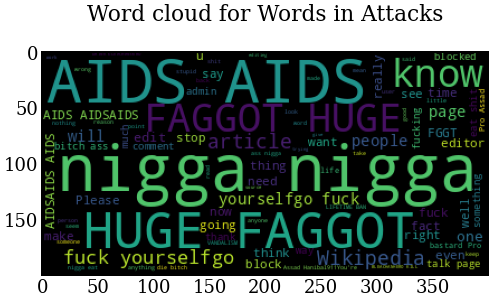

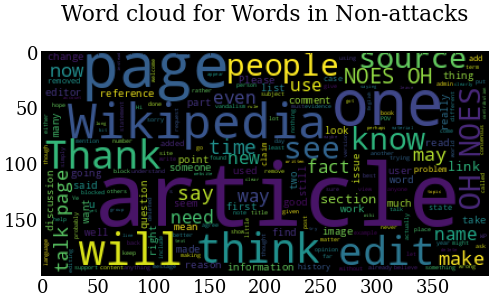

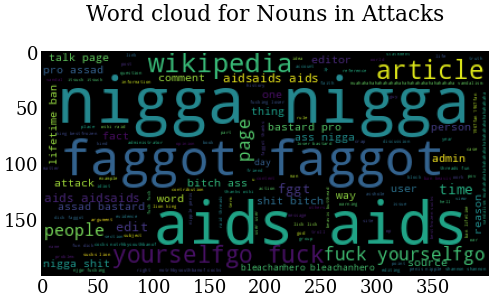

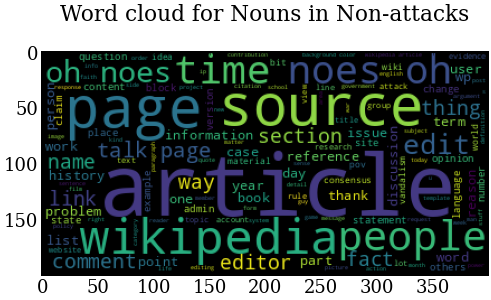

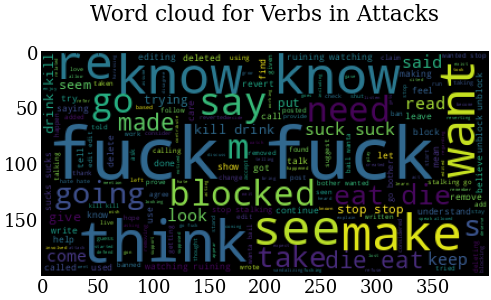

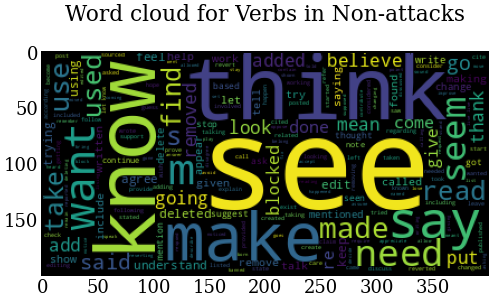

In [ ]:
words_attack = ' '.join(df[df.attack == 1]['text'])
wc_attack = WordCloud().generate(words_attack)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Words in Attacks\n")
plt.imshow(wc_attack)
plt.savefig(os.path.join(plot_path, "wc_words_attack.png"), dpi=300)

words_non_attack = ' '.join(df[df.attack == 0]['text'])
wc_non_attack = WordCloud().generate(words_non_attack)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Words in Non-attacks\n")
plt.imshow(wc_non_attack)
plt.savefig(os.path.join(plot_path, "wc_words_nattack.png"), dpi=300)

attack_nouns = ' '.join(df[df.attack == 1]['nouns'].sum())
attack_nouns_wc = WordCloud().generate(attack_nouns)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Nouns in Attacks\n")
plt.imshow(attack_nouns_wc)
plt.savefig(os.path.join(plot_path, "wc_nouns_attack.png"), dpi=300)

nattack_nouns = ' '.join(df[df.attack == 0]['nouns'].sum())
nattack_nouns_wc = WordCloud().generate(nattack_nouns)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Nouns in Non-attacks\n")
plt.imshow(nattack_nouns_wc)
plt.savefig(os.path.join(plot_path, "wc_nouns_nattack.png"), dpi=300)

attack_verbs = ' '.join(df[df.attack == 1]['verbs'].sum())
attack_verbs_wc = WordCloud().generate(attack_verbs)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Verbs in Attacks\n")
plt.imshow(attack_verbs_wc)
plt.savefig(os.path.join(plot_path, "wc_verbs_attack.png"), dpi=300)

nattack_verbs = ' '.join(df[df.attack == 0]['verbs'].sum())
nattack_verbs_wc = WordCloud().generate(nattack_verbs)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Verbs in Non-attacks\n")
plt.imshow(nattack_verbs_wc)
plt.savefig(os.path.join(plot_path, "wc_verbs_nattack.png"), dpi=300)

In [ ]:
def specific_word_counts(df):
    """
    Count specific words
    """

    df['fu**_cnt'] = df.text.apply(lambda x: 1 if ('fuck' in x.lower()) else 0)
    df['n***_cnt'] = df.text.apply(lambda x: 1 if ('nigg' in x.lower()) else 0)
    df['f*g_cnt'] = df.text.apply(lambda x: 1 if ('fag' in x.lower()) or ('fgg' in x.lower()) else 0)
    df['aids_cnt'] = df.text.apply(lambda x: 1 if ('aids' in x.lower()) else 0)
    df['article_cnt'] = df.text.apply(lambda x: 1 if ('article' in x.lower()) else 0)
    df['page_cnt'] = df.text.apply(lambda x: 1 if ('page' in x.lower()) else 0)
    df['wiki_cnt'] = df.text.apply(lambda x: 1 if ('wiki' in x.lower()) or ('wp' in x.lower()) else 0)
    df['block_cnt'] = df.text.apply(lambda x: 1 if ('block' in x.lower()) else 0)
    df['source_cnt'] = df.text.apply(lambda x: 1 if ('source' in x.lower()) else 0)

    return df

In [ ]:
new_df = specific_word_counts(new_df)
new_df.head()

,id,attack,text,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,...,caps_word_count,fu**_cnt,n***_cnt,f*g_cnt,aids_cnt,article_cnt,page_cnt,wiki_cnt,block_cnt,source_cnt
0,348598183,0,which may contain more details,26,5,7,1,5.0,5.20,1.4,...,0,0,0,0,0,0,0,0,0,0
1,61527923,1,"Regardless, the point is that I am willing to ...",264,55,87,1,55.0,4.80,1.6,...,0,0,0,0,0,1,0,0,0,0
2,325989249,0,Lede \nI'm reverting (again) the additions to...,308,63,90,3,21.0,4.89,1.4,...,0,0,0,0,0,0,0,0,0,0
3,197250961,0,I just came to this page and was wondering why...,159,41,51,1,41.0,3.88,1.2,...,0,0,0,0,0,0,1,0,0,1
4,116195271,1,It's worth having an illustration. The Type 2...,117,21,39,1,21.0,5.57,1.9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# save the processed dataframe
new_df.to_csv(os.path.join(processed, "train_numeric.csv"), index=False)

## Exploring Numerical Features

In [ ]:
df = pd.read_csv(os.path.join(processed, "train_numeric.csv"))
df.head()

,id,attack,text,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,...,caps_word_count,fu**_cnt,n***_cnt,f*g_cnt,aids_cnt,article_cnt,page_cnt,wiki_cnt,block_cnt,source_cnt
0,348598183,0,which may contain more details,26,5,7,1,5.0,5.20,1.4,...,0,0,0,0,0,0,0,0,0,0
1,61527923,1,"Regardless, the point is that I am willing to ...",264,55,87,1,55.0,4.80,1.6,...,0,0,0,0,0,1,0,0,0,0
2,325989249,0,Lede \nI'm reverting (again) the additions to...,308,63,90,3,21.0,4.89,1.4,...,0,0,0,0,0,0,0,0,0,0
3,197250961,0,I just came to this page and was wondering why...,159,41,51,1,41.0,3.88,1.2,...,0,0,0,0,0,0,1,0,0,1
4,116195271,1,It's worth having an illustration. The Type 2...,117,21,39,1,21.0,5.57,1.9,...,0,0,0,0,0,0,0,0,0,0


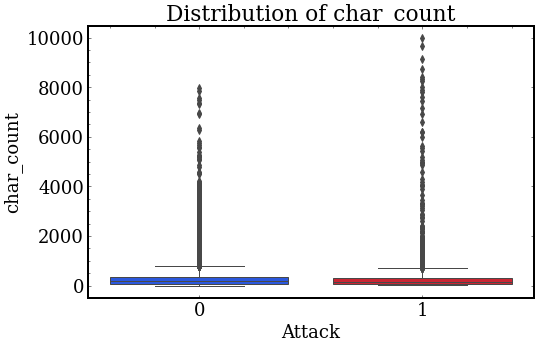

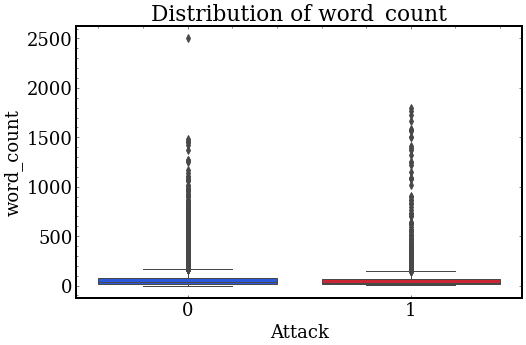

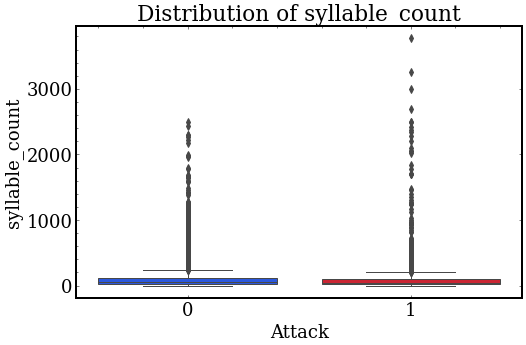

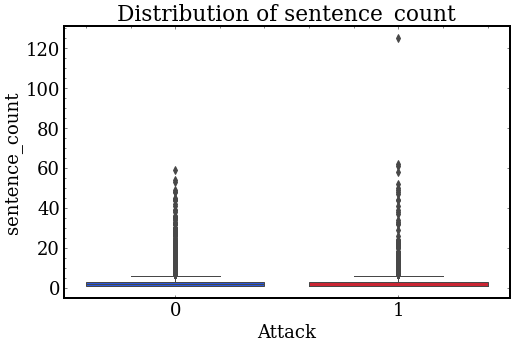

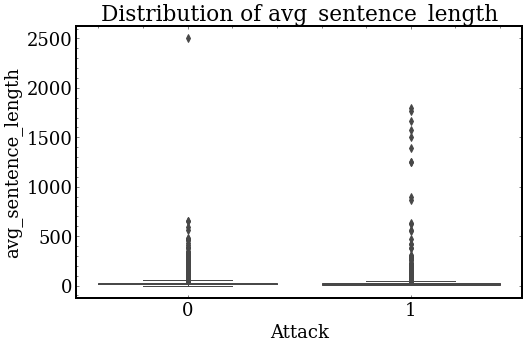

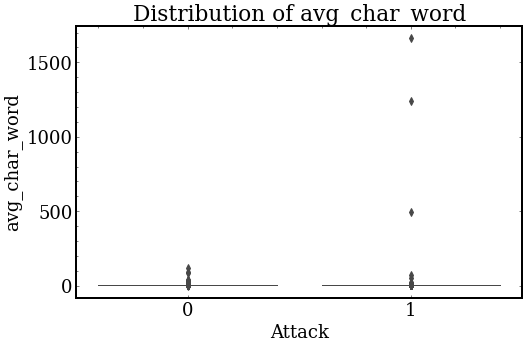

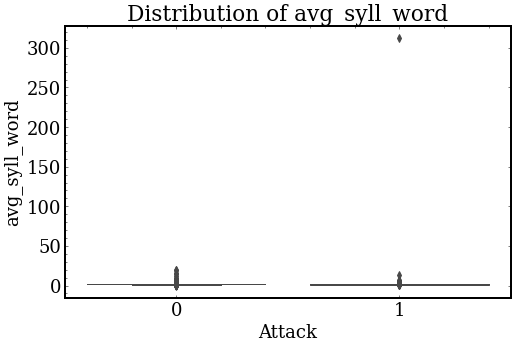

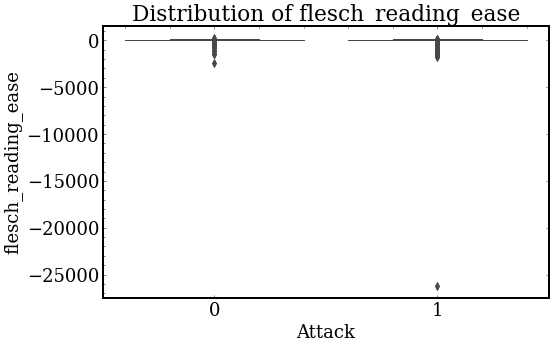

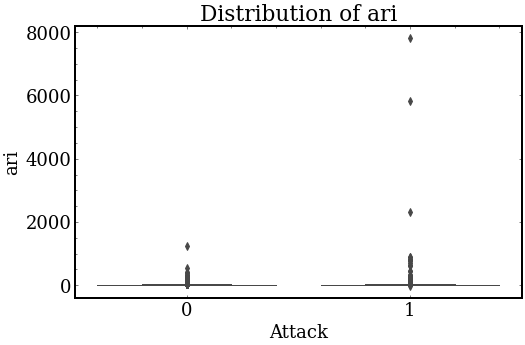

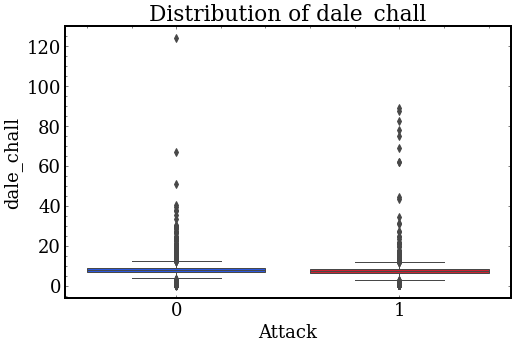

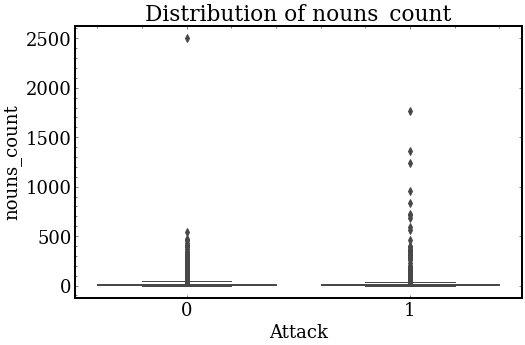

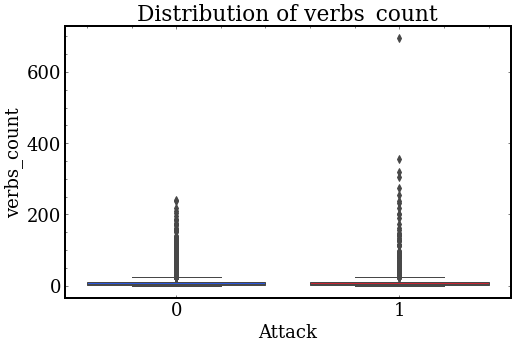

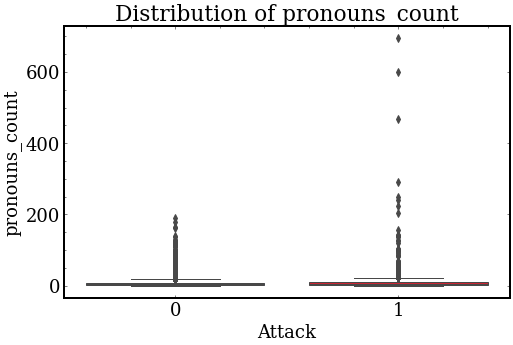

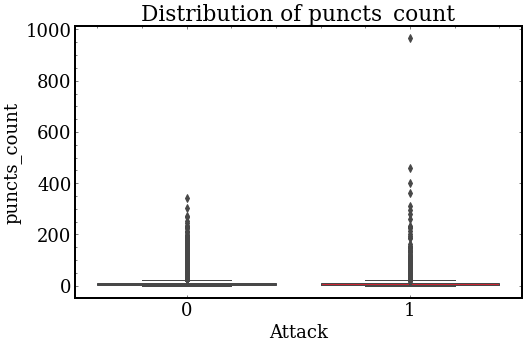

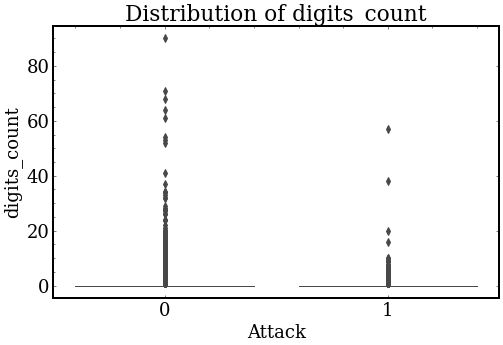

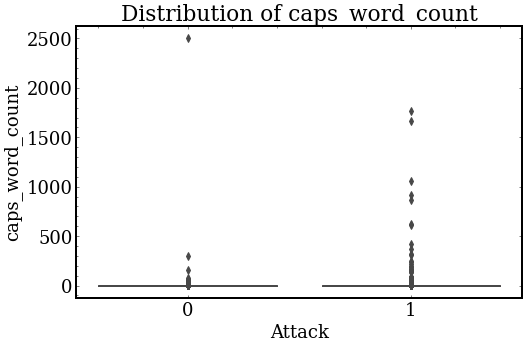

In [ ]:
# plot distributions of numerical features; show outliers

for col in df.columns:

    if col in ['id', 'attack', 'text', 'nlp', 'nouns', 'verbs', 'pronouns', 'puncts', 'digits', 'caps_word',
    'fu**_cnt', 'n***_cnt', 'f*g_cnt', 'aids_cnt', 'article_cnt', 'page_cnt', 'wiki_cnt', 'block_cnt', 'source_cnt']:
        pass
    else:
        plt.figure(figsize=(8,5))
        ax = sns.boxplot(x='attack', data=df, y=col, showfliers=True)
        ax.set_title("Distribution of "+col)
        ax.set_xlabel("Attack")
        plt.show()
        print()

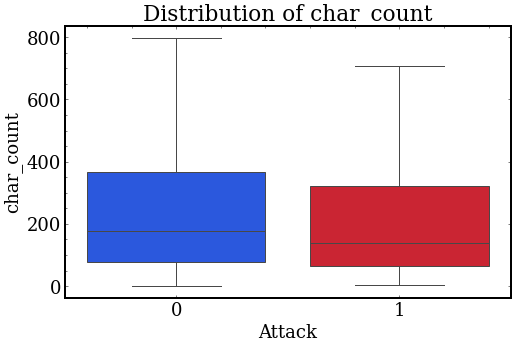

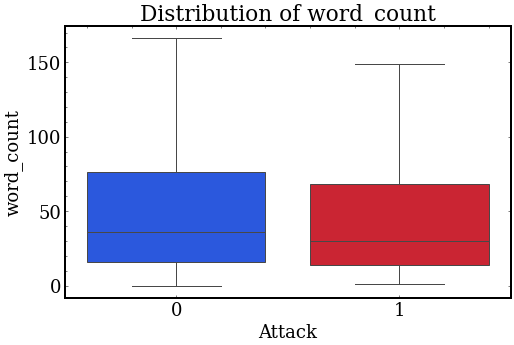

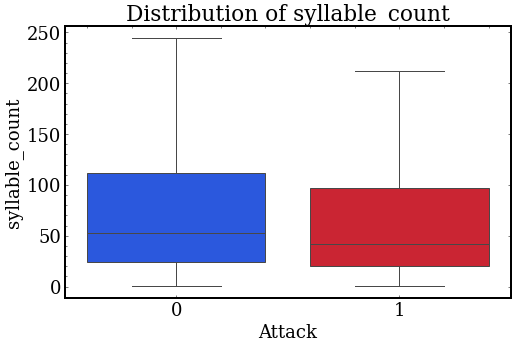

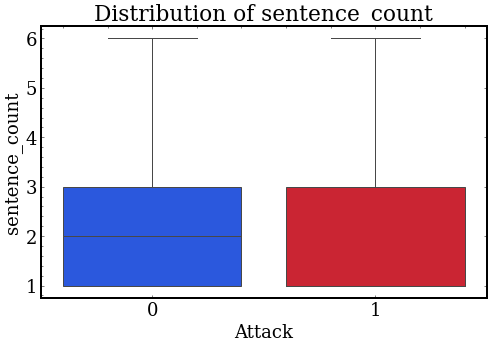

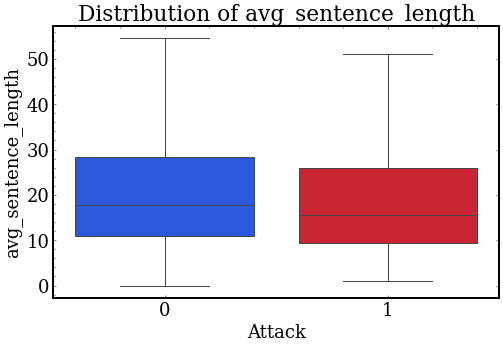

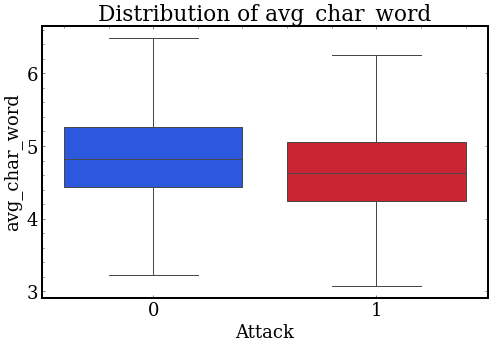

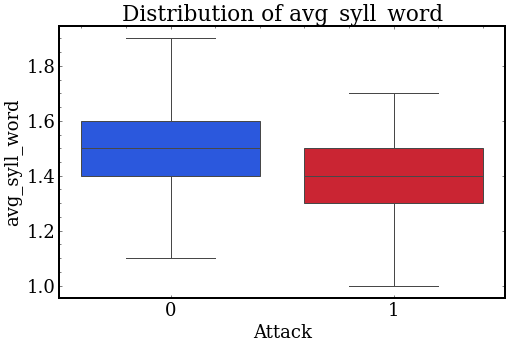

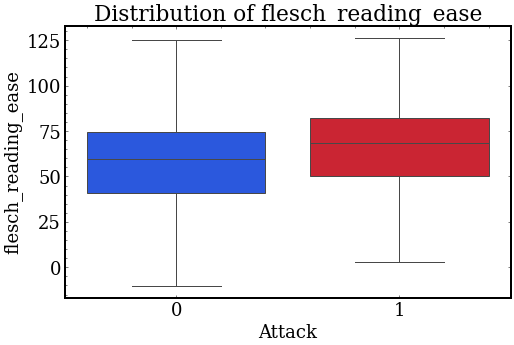

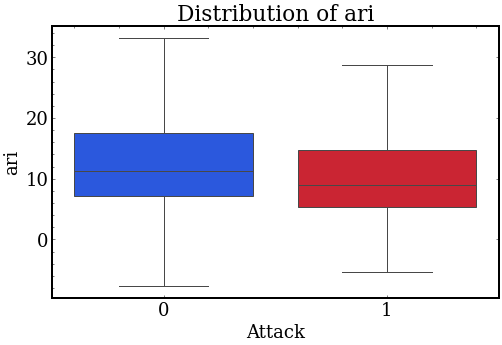

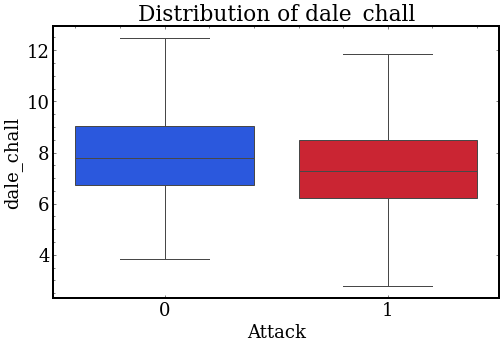

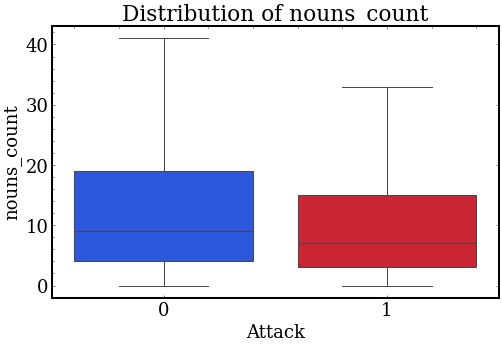

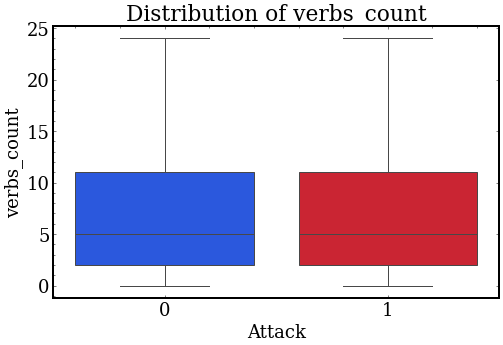

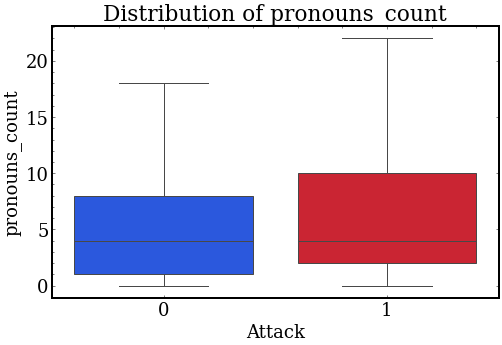

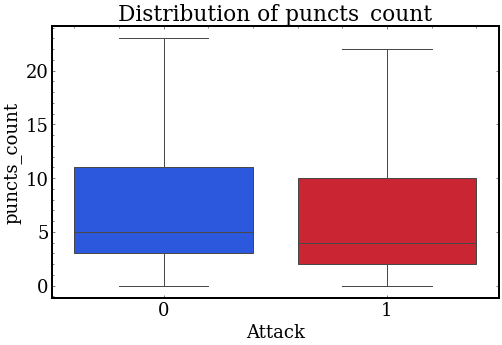

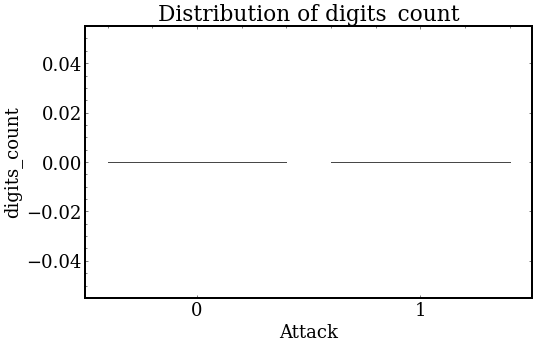

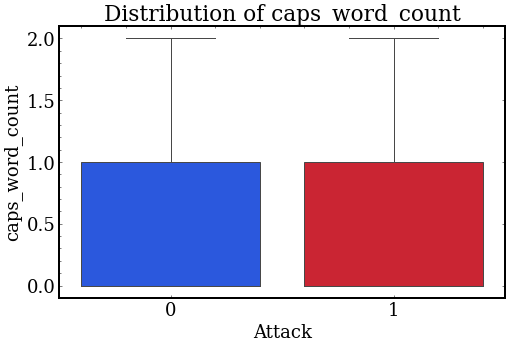

In [ ]:
# plot distributions of numerical features; hide outliers

for col in df.columns:

    if col in ['id', 'attack', 'text', 'nlp', 'nouns', 'verbs', 'pronouns', 'puncts', 'digits', 'caps_word',
    'fu**_cnt', 'n***_cnt', 'f*g_cnt', 'aids_cnt', 'article_cnt', 'page_cnt', 'wiki_cnt', 'block_cnt', 'source_cnt']:
        pass
    else:
        plt.figure(figsize=(8,5))
        ax = sns.boxplot(x='attack', data=df, y=col, showfliers=False)
        ax.set_title("Distribution of "+col)
        ax.set_xlabel("Attack")
        plt.show()
        print()

In [ ]:
for col in ['fu**_cnt', 'n***_cnt', 'f*g_cnt', 'aids_cnt', 'article_cnt', 'page_cnt', 'wiki_cnt', 'block_cnt', 'source_cnt']:

    print(df[col].value_counts())

0    14480
1      520
Name: fu**_cnt, dtype: int64
0    14953
1       47
Name: n***_cnt, dtype: int64
0    14882
1      118
Name: f*g_cnt, dtype: int64
0    14977
1       23
Name: aids_cnt, dtype: int64
0    11600
1     3400
Name: article_cnt, dtype: int64
0    12137
1     2863
Name: page_cnt, dtype: int64
0    11645
1     3355
Name: wiki_cnt, dtype: int64
0    13894
1     1106
Name: block_cnt, dtype: int64
0    13638
1     1362
Name: source_cnt, dtype: int64


In [ ]:
STOPWORDS.append(['fuck', 'fag', 'faggot', 'fggt', 'nigga', 'nigger', 'aids', 'article', 'page', 'wiki', 'wp', 'block'])

There are 3222 samples that are attacks in the training data. In comparison to that, the number of samples that contain words like fu\*\*, n\*\*\*\* and f\*g are very small as seen in the output of the above cell.

The next question then is whether the existence of these words could help classify a sample as an attack or not an attack?

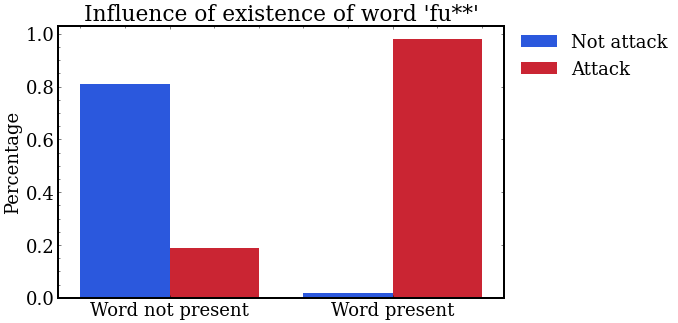

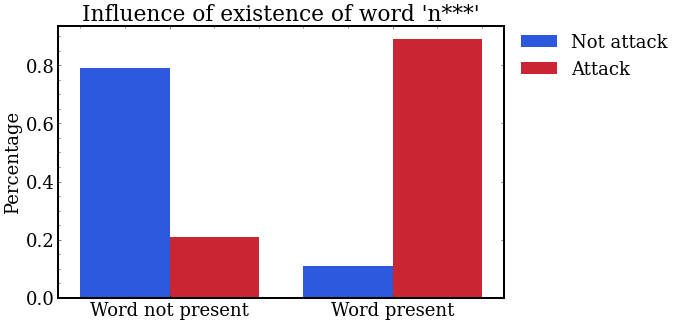

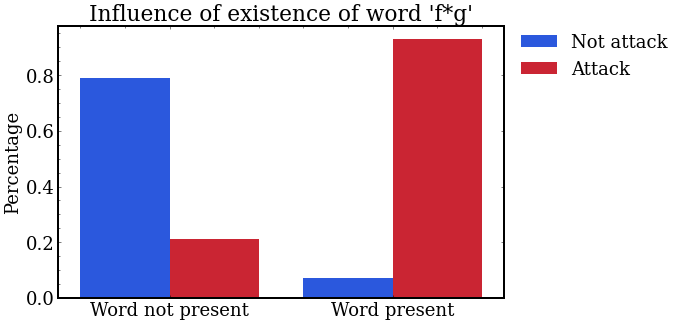

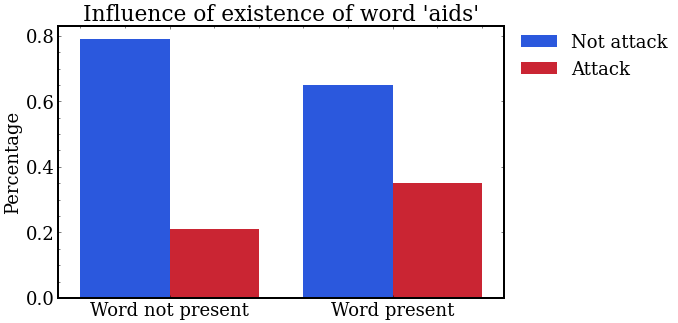

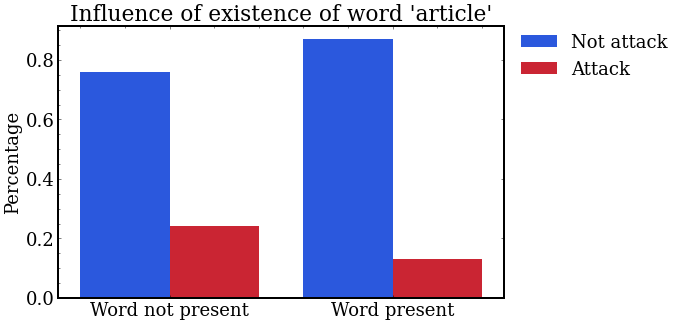

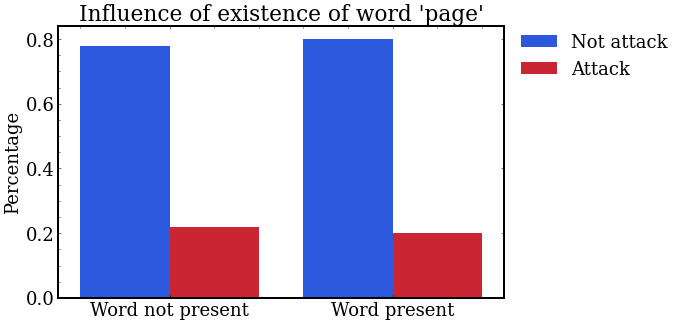

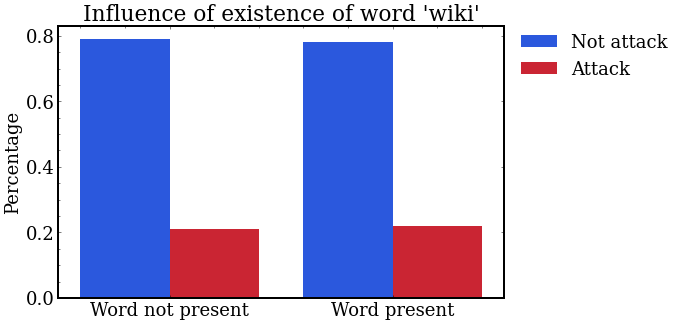

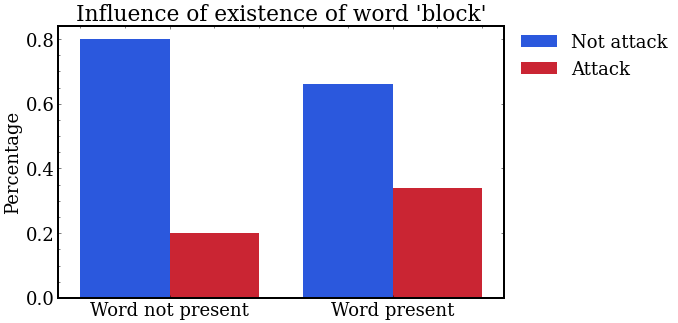

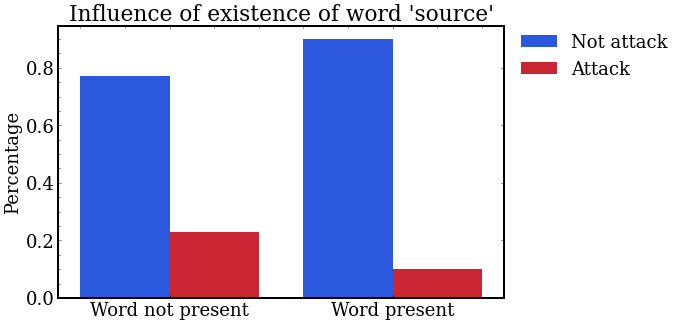

In [ ]:
for col in ['fu**_cnt', 'n***_cnt', 'f*g_cnt', 'aids_cnt', 'article_cnt', 'page_cnt', 'wiki_cnt', 'block_cnt', 'source_cnt']:

    ct = pd.crosstab(df[col], df['attack'], normalize='index')
    vals = [round(ct[0][0], 2), round(ct[1][0], 2), round(ct[0][1], 2), round(ct[1][1], 2)]
    existence = ['Word not present', 'Word not present', 'Word present', 'Word present']
    attack = ['Not attack', 'Attack', 'Not attack', 'Attack']
    temp = pd.DataFrame(
        dict(
            exist = existence,
            att = attack,
            val = vals
        )
    )
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='exist', y='val', data=temp, hue='att')
    ax.set_title("Influence of existence of word '"+col.split('_')[0]+"'")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("")
    ax.legend().set_title("")
    ax.set_xticklabels(['Word not present', 'Word present'])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    print()

- The presence of fu\*\*, n\*\*\*\* and f\*g almost certainly indicate the sample to be an attack.
- The other words' presence in a comment works the opposite way. However, even the absence of these words also follow the same pattern. Therefore, their presence does not provide a very strong predictive advantage.

Therefore, the other words, article, aids, page, wiki, source and block can be considered as stopwords. More on this after the statistical testing.

In [ ]:
df.describe()

,id,attack,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,flesch_reading_ease,...,caps_word_count,fu**_cnt,n***_cnt,f*g_cnt,aids_cnt,article_cnt,page_cnt,wiki_cnt,block_cnt,source_cnt
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2.996744e+08,0.214800,337.677067,68.081667,101.87820,2.850600,27.006147,5.225868,1.525587,50.360061,...,2.140000,0.034667,0.003133,0.007867,0.001533,0.226667,0.190867,0.223667,0.073733,0.090800
std,1.976924e+08,0.410697,596.335543,116.140985,179.48356,3.856225,54.011115,17.448351,2.570710,224.084148,...,33.497124,0.182940,0.055890,0.088348,0.039129,0.418689,0.392997,0.416715,0.261345,0.287334
min,3.767500e+04,0.000000,2.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,-26175.510000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.281649e+08,0.000000,76.000000,16.000000,23.00000,1.000000,10.800000,4.400000,1.300000,42.410000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.692862e+08,0.000000,168.000000,35.000000,51.00000,2.000000,17.000000,4.780000,1.500000,61.380000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.558264e+08,0.000000,358.000000,74.000000,109.00000,3.000000,28.000000,5.220000,1.600000,76.560000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.997562e+08,1.000000,9964.000000,2500.000000,3769.00000,125.000000,2500.000000,1660.670000,311.800000,206.840000,...,2500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Statistical testing to identify if a particular feature has an effect on `attack`

In [ ]:
numeric = list(set(df.columns) - set(['id', 'text', 'nlp', 'nouns', 'verbs', 'pronouns', 'puncts', 'digits', 'caps_word']))
df_num = df[numeric]
df_num.head()

,article_cnt,block_cnt,source_cnt,page_cnt,pronouns_count,f*g_cnt,avg_char_word,puncts_count,digits_count,char_count,...,aids_cnt,word_count,flesch_reading_ease,attack,nouns_count,ari,sentence_count,wiki_cnt,caps_word_count,n***_cnt
0,0,0,0,0,0,0,5.20,0,0,26,...,0,5,83.32,0,1,5.6,1,0,0,0
1,1,0,0,0,9,0,4.80,6,0,264,...,0,55,15.65,1,10,28.7,1,0,0,0
2,0,0,0,0,3,0,4.89,12,0,308,...,0,63,67.08,0,16,12.1,3,0,0,0
3,0,0,1,1,7,0,3.88,1,0,159,...,0,41,63.70,0,7,17.3,1,0,0,0
4,0,0,0,0,2,0,5.57,7,1,117,...,0,21,24.78,1,4,15.3,1,0,0,0


In [ ]:
# T-test for equality of means; continuous features

p_dict = {}
unequal_means = []

for col in df_num.columns:
    if col not in ['attack', 'fu**_cnt', 'n***_cnt', 'f*g_cnt', 'aids_cnt', 'article_cnt', 'page_cnt', 'wiki_cnt', 'block_cnt', 'source_cnt']:
        attack = df_num[df_num.attack==1][col]
        nattack = df_num[df_num.attack==0][col]
        stat, p_l = stats.levene(attack, nattack)  # check for equal variance
        if p_l < 0.05:
            stat, p_t = stats.ttest_ind(attack, nattack, equal_var=False)   # t-test
            p_dict[col] = p_t
            if p_t < 0.05:
                unequal_means.append(col)
        else:
            stat, p_t = stats.ttest_ind(attack, nattack, equal_var=True)   # t-test
            p_dict[col] = p_t
            if p_t < 0.05:
                unequal_means.append(col)

print("Columns that exhibit statistically significant differences in attack and non-attack comments are", unequal_means)

Columns that exhibit statistically significant differences in attack and non-attack comments are ['pronouns_count', 'digits_count', 'dale_chall', 'caps_word_count']


In [ ]:
# individually check the p-values
p_dict

{'pronouns_count': 3.86035416486508e-09,
 'avg_char_word': 0.2350489684105603,
 'puncts_count': 0.21972701619227153,
 'digits_count': 5.006933489174704e-22,
 'char_count': 0.485044283024904,
 'dale_chall': 1.707562266908403e-09,
 'avg_sentence_length': 0.06304899629840574,
 'syllable_count': 0.28965444781417,
 'avg_syll_word': 0.7970148454090501,
 'verbs_count': 0.1891210149967928,
 'word_count': 0.5623995426163457,
 'flesch_reading_ease': 0.6231362110443879,
 'nouns_count': 0.6106360796601304,
 'ari': 0.10740157657212733,
 'sentence_count': 0.22190247580933223,
 'caps_word_count': 3.4689658961955646e-05}

## Fitting a linear model with the above features

In [ ]:
import statsmodels.formula.api as sf

In [ ]:
# use all numerical features
Y = df_num['attack']
X = df_num.drop(['attack'], axis=1)
model = sm.Logit(Y,X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.430007
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 attack   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14975
Method:                           MLE   Df Model:                           24
Date:                Tue, 18 May 2021   Pseudo R-squ.:                  0.1735
Time:                        03:55:42   Log-Likelihood:                -6450.1
converged:                       True   LL-Null:                       -7803.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
article_cnt            -0.5219      0.065     -7.991      0.000      -0.650      -0.394
block_cnt               0.5108      0.076      6.684      0.000       0.361       0.661
source_cnt             -0.6184      0.101     -6.120      0.000      -0.816      -0.420
page_cnt               -0.1755      0.061     -2.876      0.004      -0.295      -0.056
pronouns_count          0.1098      0.007     14.963      0.000       0.095       0.124
f*g_cnt                 3.7814      0.393      9.615      0.000       3.011       4.552
avg_char_word           2.4598      3.101      0.793      0.428      -3.618       8.538
puncts_count           -0.0039      0.002     -1.767      0.077      -0.008       0.000
digits_count           -0.1445      0.025     -5.867      0.000      -0.193      -0.096
char_count              0.0027      0.001      3.902      0.000       0.001       0.004
dale_chall             -0.0827      0.009     -8.730      0.000      -0.101      -0.064
avg_sentence_length     0.2084      0.260      0.802      0.422      -0.301       0.718
syllable_count        1.59e-05      0.002      0.007      0.994      -0.004       0.004
avg_syll_word          -5.0500      5.778     -0.874      0.382     -16.375       6.275
verbs_count             0.0215      0.007      3.010      0.003       0.008       0.036
fu**_cnt                5.6354      0.395     14.278      0.000       4.862       6.409
aids_cnt                0.6136      0.575      1.067      0.286      -0.513       1.741
word_count             -0.0328      0.003     -9.473      0.000      -0.040      -0.026
flesch_reading_ease    -0.0585      0.068     -0.857      0.392      -0.192       0.075
nouns_count             0.0142      0.003      5.642      0.000       0.009       0.019
ari                    -0.5195      0.658     -0.789      0.430      -1.810       0.770
sentence_count          0.0588      0.016      3.587      0.000       0.027       0.091
wiki_cnt                0.1475      0.058      2.546      0.011       0.034       0.261
caps_word_count         0.0079      0.002      4.501      0.000       0.004       0.011
n***_cnt                2.9362      0.594      4.941      0.000       1.771       4.101
=======================================================================================
"""

In [ ]:
results.pred_table()

array([[11676.,   102.],
       [ 2546.,   676.]])

In [ ]:
## marginal effects
mfx = results.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                 attack
Method:                          dydx
At:                           overall
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
article_cnt            -0.0704      0.009     -8.014      0.000      -0.088      -0.053
block_cnt               0.0689      0.010      6.712      0.000       0.049       0.089
source_cnt             -0.0833      0.014     -6.129      0.000      -0.110      -0.057
page_cnt               -0.0236      0.008     -2.878      0.004      -0.040      -0.008
pronouns_count          0.0148      0.001     15.197      0.000       0.013       0.017
f*g_cnt                 0.5097      0.053      9.699      0.000       0.407       0.613
avg_char_word           0.3316      0.418      0.793      0.428      -0.488       1.151
puncts_count           -0.0005      0.000     -1.768    

In [ ]:
# use filtered numerical features
Y = df_num['attack']
X = df_num[['caps_word_count', 'digits_count', 'pronouns_count', 'dale_chall', 'fu**_cnt', 'n***_cnt', 'f*g_cnt']]
model = sm.Logit(Y,X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.456940
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 attack   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14993
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 May 2021   Pseudo R-squ.:                  0.1217
Time:                        03:56:04   Log-Likelihood:                -6854.1
converged:                       True   LL-Null:                       -7803.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
caps_word_count     0.0106      0.001     11.285      0.000       0.009       0.012
digits_count       -0.2546      0.025    -10.116      0.000      -0.304      -0.205
pronouns_count      0.0192      0.002     10.666      0.000       0.016       0.023
dale_chall         -0.1951      0.003    -57.578      0.000      -0.202      -0.188
fu**_cnt            5.6961      0.409     13.939      0.000       4.895       6.497
n***_cnt            3.1758      0.624      5.090      0.000       1.953       4.399
f*g_cnt             4.2198      0.433      9.735      0.000       3.370       5.069
===================================================================================
"""

In [ ]:
# use filtered numerical features
Y = df_num['attack']
X = df_num[['caps_word_count', 'digits_count', 'pronouns_count', 'dale_chall', 'fu**_cnt', 'f*g_cnt', 'n***_cnt']]
model = sm.Logit(Y,X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.456940
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 attack   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14993
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 May 2021   Pseudo R-squ.:                  0.1217
Time:                        03:56:58   Log-Likelihood:                -6854.1
converged:                       True   LL-Null:                       -7803.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
caps_word_count     0.0106      0.001     11.285      0.000       0.009       0.012
digits_count       -0.2546      0.025    -10.116      0.000      -0.304      -0.205
pronouns_count      0.0192      0.002     10.666      0.000       0.016       0.023
dale_chall         -0.1951      0.003    -57.578      0.000      -0.202      -0.188
fu**_cnt            5.6961      0.409     13.939      0.000       4.895       6.497
f*g_cnt             4.2198      0.433      9.735      0.000       3.370       5.069
n***_cnt            3.1758      0.624      5.090      0.000       1.953       4.399
===================================================================================
"""

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

import numpy as np

In [ ]:
# get the estimator i.e pipeline
estimator = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', ComplementNB())
])

Y = df_num['attack'].values
X = df_num[['caps_word_count', 'digits_count', 'pronouns_count', 'dale_chall', 'block_cnt', 'article_cnt', 'source_cnt']]
# cross validate
cv_f1_scores = cross_val_score(estimator, X, Y, cv=5, scoring='f1', error_score='raise')
print(np.mean(cv_f1_scores))
print(cv_f1_scores)

0.3926949904438742
[0.39003559 0.38930481 0.39447592 0.39432624 0.39533239]


article_cnt, source_cnt and block_cnt have been added as they improve performance on this baseline estimator and also because these variables make sense (based on the visualizations).

## Adding intuitive features

I expect that
- Attacks will have more negative sentiment than non-attacks
- Attacks will use more "you" than non-attacks
- Attackers will use more "!" marks than non-attackers

Basing my analysis on these two points, I am engineering two new features.

In [ ]:
from afinn import Afinn
afinn = Afinn()

In [ ]:
df['afinn'] = df.text.apply(afinn.score)
df['you_count'] = df.text.apply(lambda x: x.lower().count('you'))
df['!_count'] = df.text.apply(lambda x: 1 if '!' in x else 0)
df.head()

,id,attack,text,char_count,word_count,syllable_count,sentence_count,avg_sentence_length,avg_char_word,avg_syll_word,...,f*g_cnt,aids_cnt,article_cnt,page_cnt,wiki_cnt,block_cnt,source_cnt,afinn,you_count,!_count
0,348598183,0,which may contain more details,26,5,7,1,5.0,5.20,1.4,...,0,0,0,0,0,0,0,0.0,0,0
1,61527923,1,"Regardless, the point is that I am willing to ...",264,55,87,1,55.0,4.80,1.6,...,0,0,1,0,0,0,0,3.0,4,0
2,325989249,0,Lede \nI'm reverting (again) the additions to...,308,63,90,3,21.0,4.89,1.4,...,0,0,0,0,0,0,0,-15.0,0,0
3,197250961,0,I just came to this page and was wondering why...,159,41,51,1,41.0,3.88,1.2,...,0,0,0,1,0,0,1,-5.0,0,0
4,116195271,1,It's worth having an illustration. The Type 2...,117,21,39,1,21.0,5.57,1.9,...,0,0,0,0,0,0,0,-3.0,0,0


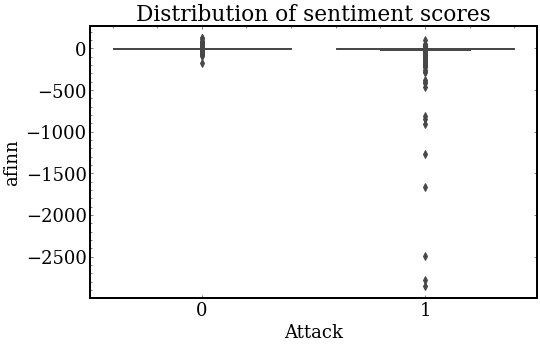

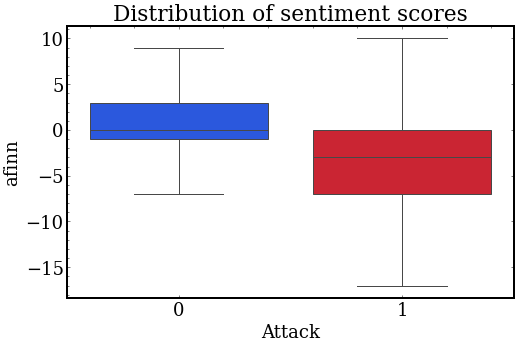

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(x='attack', data=df, y='afinn', showfliers=True)
ax.set_title("Distribution of sentiment scores")
ax.set_xlabel("Attack")
plt.show()

plt.figure(figsize=(8,5))
ax = sns.boxplot(x='attack', data=df, y='afinn', showfliers=False)
ax.set_title("Distribution of sentiment scores")
ax.set_xlabel("Attack")
plt.show()

There seems to be a visually evident difference in sentiment scores between attacks and non-attacks.

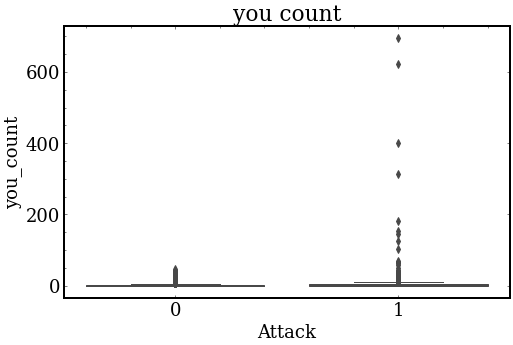

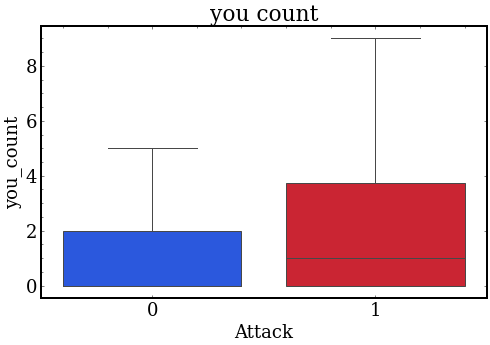

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.boxplot(x='attack', data=df, y='you_count', showfliers=True)
ax.set_title("you count")
ax.set_xlabel("Attack")
plt.show()

plt.figure(figsize=(8,5))
ax = sns.boxplot(x='attack', data=df, y='you_count', showfliers=False)
ax.set_title("you count")
ax.set_xlabel("Attack")
plt.show()

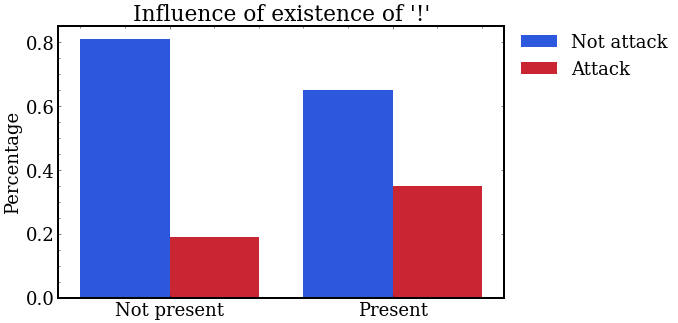

In [ ]:
col = '!_count'
ct = pd.crosstab(df[col], df['attack'], normalize='index')
vals = [round(ct[0][0], 2), round(ct[1][0], 2), round(ct[0][1], 2), round(ct[1][1], 2)]
existence = ['Word not present', 'Word not present', 'Word present', 'Word present']
attack = ['Not attack', 'Attack', 'Not attack', 'Attack']
temp = pd.DataFrame(
    dict(
        exist = existence,
        att = attack,
        val = vals
    )
)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='exist', y='val', data=temp, hue='att')
ax.set_title("Influence of existence of '"+col.split('_')[0]+"'")
ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.legend().set_title("")
ax.set_xticklabels(['Not present', 'Present'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
print()

In [ ]:
# get the estimator i.e pipeline
estimator = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', ComplementNB())
])

Y = df['attack'].values
X = df[['afinn', 'you_count', 'caps_word_count', 'digits_count', 'dale_chall']]
# cross validate
cv_f1_scores = cross_val_score(estimator, X, Y, cv=5, scoring='f1', error_score='raise')
print(np.mean(cv_f1_scores))
print(cv_f1_scores)

0.42962527900376235
[0.44418193 0.42446043 0.43516007 0.4173913  0.42693267]


The selection of continuous features has been refined again.

**5 numerical features are thus chosen =>** 'afinn', 'you_count', 'caps_word_count', 'digits_count', 'dale_chall'

The 'article_count', 'source_cnt', 'fu\*\*_count', 'n\*\*\*_cnt and 'f\*g_cnt' binary variables are also selected inspite of their addition not increasing the above performance. These 5 variables can be used to create a heuristical model that can classify a comment. Doing so will help remove these words from the text as stopwords due to their large (and sometimes uneven) frequencies.

The **heuristical model** follows 3 simple rules:  
1. If 'article' or 'source' present, classify as not-attack  
2. If 'fu\*\*' or 'n\*\*\*' or 'f\*g' present, classify as attack  
3. Rule 2 has higher precedence than rule 1

## Exploring common CAPS words

Which common CAPS words are present in the corpus? Do these words have any kind of predictive power on their own? Or can they be added to the list fo stopwords?

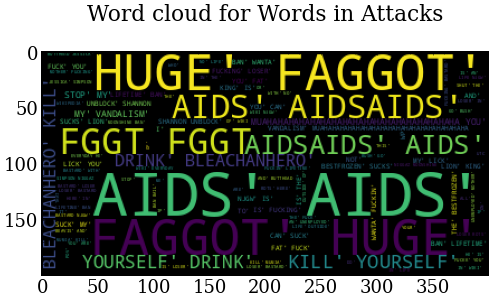

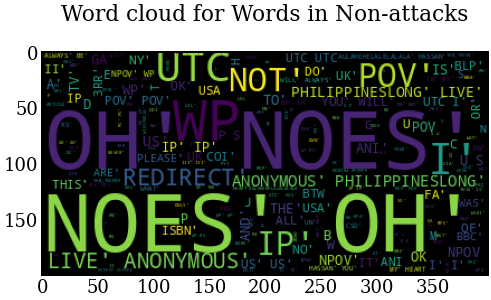

In [ ]:
words_attack = ' '.join(df[df.attack == 1]['caps_word'])
wc_attack = WordCloud().generate(words_attack)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Words in Attacks\n")
plt.imshow(wc_attack)
#plt.savefig(os.path.join(plot_path, "wc_words_attack.png"), dpi=300)

words_attack = ' '.join(df[df.attack == 0]['caps_word'])
wc_attack = WordCloud().generate(words_attack)
plt.figure(figsize=(8,5))
plt.title("Word cloud for Words in Non-attacks\n")
plt.imshow(wc_attack)

In [ ]:
df['NOES_count'] = df.text.apply(lambda x: 1 if 'NOES' in x else 0)
df['ANONYMOUS_count'] = df.text.apply(lambda x: 1 if 'ANONYMOUS' in x else 0)
df['UTC_count'] = df.text.apply(lambda x: 1 if 'UTC' in x else 0)
df['NOT_count'] = df.text.apply(lambda x: 1 if 'NOT' in x else 0)
df['OH_count'] = df.text.apply(lambda x: 1 if 'OH' in x else 0) 
df['IP_count'] = df.text.apply(lambda x: 1 if 'IP' in x else 0) 
df['POV_count'] = df.text.apply(lambda x: 1 if 'POV' in x else 0)
df['PHILIPPINESLONG_count'] = df.text.apply(lambda x: 1 if 'PHILIPPINESLONG' in x else 0)
df['LIVE_count'] = df.text.apply(lambda x: 1 if 'LIVE' in x else 0)
df['WP_count'] = df.text.apply(lambda x: 1 if 'WP' in x else 0)
df['REDIRECT_count'] = df.text.apply(lambda x: 1 if 'REDIRECT' in x else 0)
df['BTW_count'] = df.text.apply(lambda x: 1 if 'BTW' in x else 0)
df['AIDS_count'] = df.text.apply(lambda x: 1 if 'AIDS' in x else 0)
df['HUGE_count'] = df.text.apply(lambda x: 1 if 'HUGE' in x else 0)
df['BLEACHANHERO_count'] = df.text.apply(lambda x: 1 if 'BLEACHANHERO' in x else 0)

Using the same barplot and value_counts() method as before, it is found that all the words in the cell above could be potential stopwords. Inspite of having large frequencies, most of them are present in under 20-30 comments of all 15000 comments present in the training data. 

The presence of REDIRECT is very strong in comments that are not attacks and therefore, this variable will be added to the heuristical rules. The modified **heuristical model** follows 3 simple rules:  

1. If 'article' or 'source' or 'REDIRECT' present, classify as not-attack  
2. If 'fu\*\*' or 'n\*\*\*' or 'f\*g' present, classify as attack  
3. Rule 2 has higher precedence than rule 1

In [ ]:
# update stopword list
STOPWORDS.append(['NOES', 'ANONYMOUS', 'UTC', 'NOT', 'OH', 'IP', 'POV', 'LIVE', 'WP', 'REDIRECT', 'BTW', 'AIDS', 'HUGE', 'BLEACHANHERO', 'PHILIPPINESLONG'])

In [ ]:
df['REDIRECT_count'].value_counts()

0    14873
1      127
Name: REDIRECT_count, dtype: int64

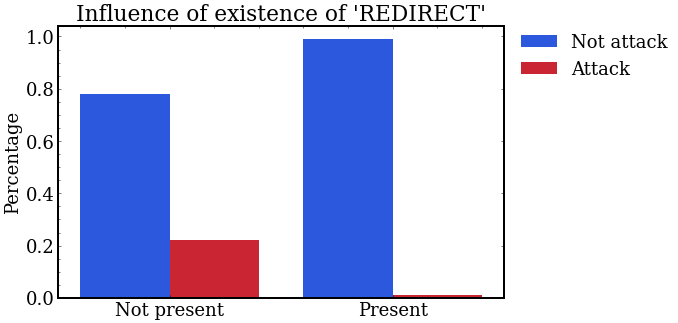

In [ ]:
col = 'REDIRECT_count'
ct = pd.crosstab(df[col], df['attack'], normalize='index')
vals = [round(ct[0][0], 2), round(ct[1][0], 2), round(ct[0][1], 2), round(ct[1][1], 2)]
existence = ['Word not present', 'Word not present', 'Word present', 'Word present']
attack = ['Not attack', 'Attack', 'Not attack', 'Attack']
temp = pd.DataFrame(
    dict(
        exist = existence,
        att = attack,
        val = vals
    )
)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='exist', y='val', data=temp, hue='att')
ax.set_title("Influence of existence of '"+col.split('_')[0]+"'")
ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.legend().set_title("")
ax.set_xticklabels(['Not present', 'Present'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()
print()

In [ ]:
# store the numeric features as a new dataset
df[['id', 'text', 'afinn', 'you_count', 'caps_word_count', 'digits_count', 'dale_chall', 'article_cnt', 'source_cnt', 'fu**_cnt', 'f*g_cnt', 'n***_cnt', 'REDIRECT_count' ,'attack']].to_csv(os.path.join(processed,'train_numeric_final.csv'), index=False)

In [ ]:
# get the stopwords discovered
print(STOPWORDS)

[['fuck', 'fag', 'faggot', 'fggt', 'nigga', 'nigger', 'aids', 'article', 'page', 'wiki', 'wp', 'block'], ['NOES', 'ANONYMOUS', 'UTC', 'NOT', 'OH', 'IP', 'POV', 'LIVE', 'WP', 'REDIRECT', 'BTW', 'AIDS', 'HUGE', 'BLEACHANHERO', 'PHILIPPINESLONG']]
